# Credit Scoring Demo

This notebook demonstrates two independent credit assessment methods:

1. **ML-Based Credit Tier Prediction** - Uses a pre-trained XGBoost model to predict credit tier (Excellent/Good/Fair/Poor) and calculate appropriate credit limits
2. **Statistical Credit Score Calculation** - Formula-based approach to calculate a traditional credit score (300-850 range)

Both methods operate independently and serve different purposes in credit risk assessment.

In [1]:
# Import required libraries
import sys
import json
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Add backend to path
sys.path.insert(0, str(Path.cwd() / 'backend'))

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## Load Sample Customer Data

We'll use customer data from our database to demonstrate both scoring methods.

In [2]:
# Load customer data
data_file = Path('data/user_data.json')
with open(data_file, 'r') as f:
    all_users = json.load(f)

# Convert to DataFrame for easier manipulation
df_all_users = pd.DataFrame(all_users)

# Select a sample customer for demonstration
sample_customer_id = 8625
sample_customer = df_all_users[df_all_users['Customer_ID'] == sample_customer_id].iloc[0]

print(f"Sample Customer: {sample_customer['Name']}")
print(f"Customer ID: {sample_customer['Customer_ID']}")
print(f"\nKey Financial Data:")
print(f"  Annual Income: ${sample_customer['Annual_Income']:,.0f}")
print(f"  Monthly Salary: ${sample_customer['Monthly_Inhand_Salary']:,.0f}")
print(f"  Outstanding Debt: ${sample_customer['Outstanding_Debt']:,.0f}")
print(f"  Credit Utilization: {sample_customer['Credit_Utilization_Ratio']:.1f}%")
print(f"  Credit History Age: {sample_customer['Credit_History_Age']:.0f} months")
print(f"  Delayed Payments: {sample_customer['Num_of_Delayed_Payment']}")
print(f"  Credit Inquiries: {sample_customer['Num_Credit_Inquiries']}")

Sample Customer: Rick Rothackerj
Customer ID: 8625

Key Financial Data:
  Annual Income: $34,848
  Monthly Salary: $4,094
  Outstanding Debt: $605
  Credit Utilization: 32.9%
  Credit History Age: 326 months
  Delayed Payments: 4
  Credit Inquiries: 2


---

# Part 1: ML-Based Credit Tier Prediction

This section uses a pre-trained XGBoost model to predict:
- **Credit Tier**: Excellent / Good / Fair / Poor
- **Credit Limit**: Maximum credit amount to approve

The model was trained on historical data and considers multiple financial factors.

## Step 1: Load Pre-trained ML Models

The model pipeline includes:
- Label encoder (converts tier names to numbers)
- Dummy column transformer (one-hot encoding for categorical variables)
- Ordinal encoder (for ordered categories)
- XGBoost classifier (the main prediction model)

In [3]:
# Import dummy transformer class
from dummy import PrepareDummyCols
import __main__
__main__.PrepareDummyCols = PrepareDummyCols

# Load the ML models
model_dir = Path('backend/model')

label_encoder = joblib.load(model_dir / 'credit_score_mul_lable_le.jlb')
dummy_transformer = joblib.load(model_dir / 'credit_score_mul_lable_coldummy.jlb')
ordinal_encoder = joblib.load(model_dir / 'credit_score_mul_lable_ordenc.jlb')
ml_model = joblib.load(model_dir / 'credit_score_mul_lable_model.jlb')

print("✓ ML models loaded successfully")
print(f"\nModel type: {type(ml_model).__name__}")
print(f"Credit tiers: {label_encoder.classes_}")

/Users/surface/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/surface/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✓ ML models loaded successfully

Model type: XGBClassifier
Credit tiers: ['Good' 'Poor' 'Standard']


/Users/surface/miniconda3/envs/ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


## Step 2: Make Prediction with ML Model

The model predicts the credit tier and provides probability scores for each tier.

In [4]:
# Prepare data for prediction
df_customer = df_all_users[df_all_users['Customer_ID'] == sample_customer_id].copy()

# Remove columns not used in prediction
df_pred = df_customer.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN', 'Credit_Score'], errors='ignore')

# Apply transformations
df_pred = dummy_transformer.transform(df_pred)
df_pred[ordinal_encoder.feature_names_in_] = ordinal_encoder.transform(df_pred[ordinal_encoder.feature_names_in_])

# Make prediction
probabilities = ml_model.predict_proba(df_pred[ml_model.feature_names_in_])[0]
prediction = label_encoder.inverse_transform(ml_model.predict(df_pred[ml_model.feature_names_in_]))[0]

print(f"ML Model Prediction:")
print(f"  Credit Tier: {prediction}")
print(f"\nProbability Distribution:")
for tier, prob in zip(label_encoder.classes_, probabilities):
    print(f"  {tier}: {prob:.1%}")

ML Model Prediction:
  Credit Tier: Good

Probability Distribution:
  Good: 88.3%
  Poor: 0.0%
  Standard: 11.7%


## Step 3: Calculate Credit Limit

The credit limit is calculated based on monthly income and the predicted tier probabilities:

$$\text{Credit Limit} = \text{Monthly Salary} \times 6 \times \text{Risk Factor}$$

where the Risk Factor is calculated as:

$$\text{Risk Factor} = 1.0 \times P(\text{Good}) + 0.5 \times P(\text{Standard}) + 0.25 \times P(\text{Poor})$$

This formula gives higher credit limits to customers with higher probability of being in good tiers.

In [5]:
# Calculate credit limit
monthly_income = df_customer['Monthly_Inhand_Salary'].values[0]
risk_factor = 1.0 * probabilities[0] + 0.5 * probabilities[1] + 0.25 * probabilities[2]
credit_limit = int(np.ceil(monthly_income * 6 * risk_factor))

print(f"Credit Limit Calculation:")
print(f"  Monthly Salary: ${monthly_income:,.0f}")
print(f"  Risk Factor: {risk_factor:.4f}")
print(f"  Calculated Credit Limit: ${credit_limit:,.0f}")
print(f"\n{'='*50}")
print(f"ML MODEL RESULT:")
print(f"  Predicted Tier: {prediction}")
print(f"  Approved Credit Limit: ${credit_limit:,.0f}")
print(f"{'='*50}")

Credit Limit Calculation:
  Monthly Salary: $4,094
  Risk Factor: 0.9122
  Calculated Credit Limit: $22,408

ML MODEL RESULT:
  Predicted Tier: Good
  Approved Credit Limit: $22,408


---

# Part 2: Statistical Credit Score (300-850)

This section calculates a traditional credit score using a weighted formula based on five key factors.

## Credit Score Formula

The final credit score is calculated as:

$$\text{Score} = 300 + 550 \times \left( \sum_{i=1}^{5} w_i \times s_i \right)$$

where:
- $w_i$ = weight for factor $i$
- $s_i$ = normalized score for factor $i$ (range: 0 to 1)
- 300 = minimum score
- 550 = score range (850 - 300)

The five factors and their weights are:

| Factor | Weight ($w_i$) | Description |
|--------|----------------|-------------|
| Credit Utilization | 50% | Percentage of available credit being used |
| Recent Inquiries | 40% | Number of recent credit applications |
| Payment History | 5% | Ratio of on-time payments |
| Credit History Length | 2.5% | Age of credit account |
| Outstanding Debt | 2.5% | Total outstanding debt amount |

## Factor 1: Payment History Score

$$s_{\text{payment}} = \frac{\text{Credit History Age} - \text{Delayed Payments}}{\text{Credit History Age}}$$

This measures the ratio of on-time payments. Higher is better.

In [6]:
# Calculate Payment History Score
credit_history_age = sample_customer['Credit_History_Age']
delayed_payments = sample_customer['Num_of_Delayed_Payment']

s_payment = (credit_history_age - delayed_payments) / credit_history_age if credit_history_age > 0 else 1.0

print(f"Payment History Calculation:")
print(f"  Credit History Age: {credit_history_age:.0f} months")
print(f"  Delayed Payments: {delayed_payments}")
print(f"  Score: ({credit_history_age:.0f} - {delayed_payments}) / {credit_history_age:.0f} = {s_payment:.4f}")
print(f"  Weight: 5%")
print(f"  Weighted contribution: {s_payment * 0.05:.4f}")

Payment History Calculation:
  Credit History Age: 326 months
  Delayed Payments: 4
  Score: (326 - 4) / 326 = 0.9877
  Weight: 5%
  Weighted contribution: 0.0494


## Factor 2: Credit Utilization Score

$$s_{\text{utilization}} = \begin{cases} 
0 & \text{if ratio} > 0.4 \\
1 - \text{ratio} & \text{otherwise}
\end{cases}$$

where $\text{ratio} = \frac{\text{Credit Utilization Ratio}}{100}$

Using more than 40% of available credit is penalized heavily. Lower utilization is better.

In [7]:
# Calculate Credit Utilization Score
utilization_ratio = sample_customer['Credit_Utilization_Ratio'] / 100

if utilization_ratio > 0.4:
    s_utilization = 0
    print(f"Credit Utilization Calculation:")
    print(f"  Utilization Ratio: {utilization_ratio:.1%}")
    print(f"  Exceeds 40% threshold - Score penalized to 0")
else:
    s_utilization = 1 - utilization_ratio
    print(f"Credit Utilization Calculation:")
    print(f"  Utilization Ratio: {utilization_ratio:.1%}")
    print(f"  Score: 1 - {utilization_ratio:.4f} = {s_utilization:.4f}")

print(f"  Weight: 50%")
print(f"  Weighted contribution: {s_utilization * 0.50:.4f}")

Credit Utilization Calculation:
  Utilization Ratio: 32.9%
  Score: 1 - 0.3293 = 0.6707
  Weight: 50%
  Weighted contribution: 0.3353


## Factor 3: Credit History Length Score

Uses percentile ranking based on normal distribution:

$$s_{\text{history}} = \Phi\left(\frac{x - \mu}{\sigma}\right)$$

where:
- $\Phi$ = Cumulative Distribution Function of standard normal distribution
- $x$ = Credit History Age (months)
- $\mu$ = 221.22 (population mean)
- $\sigma$ = 99.68 (population standard deviation)

Longer credit history is better.

In [8]:
# Calculate Credit History Length Score
mean_history = 221.22
std_history = 99.68

z_score_history = (credit_history_age - mean_history) / std_history
s_history = stats.norm.cdf(z_score_history)

print(f"Credit History Length Calculation:")
print(f"  Credit History Age: {credit_history_age:.0f} months")
print(f"  Population Mean (μ): {mean_history:.2f}")
print(f"  Population Std Dev (σ): {std_history:.2f}")
print(f"  Z-score: ({credit_history_age:.0f} - {mean_history:.2f}) / {std_history:.2f} = {z_score_history:.4f}")
print(f"  Percentile Score: Φ({z_score_history:.4f}) = {s_history:.4f}")
print(f"  Weight: 2.5%")
print(f"  Weighted contribution: {s_history * 0.025:.4f}")

Credit History Length Calculation:
  Credit History Age: 326 months
  Population Mean (μ): 221.22
  Population Std Dev (σ): 99.68
  Z-score: (326 - 221.22) / 99.68 = 1.0512
  Percentile Score: Φ(1.0512) = 0.8534
  Weight: 2.5%
  Weighted contribution: 0.0213


## Factor 4: Outstanding Debt Score

$$s_{\text{debt}} = 1 - \Phi\left(\frac{x - \mu}{\sigma}\right)$$

where:
- $x$ = Outstanding Debt amount
- $\mu$ = 1426.22 (population mean)
- $\sigma$ = 1155.13 (population standard deviation)

Lower debt is better, so we subtract from 1.

In [9]:
# Calculate Outstanding Debt Score
outstanding_debt = sample_customer['Outstanding_Debt']
mean_debt = 1426.22
std_debt = 1155.13

z_score_debt = (outstanding_debt - mean_debt) / std_debt
s_debt = 1 - stats.norm.cdf(z_score_debt)

print(f"Outstanding Debt Calculation:")
print(f"  Outstanding Debt: ${outstanding_debt:,.2f}")
print(f"  Population Mean (μ): ${mean_debt:.2f}")
print(f"  Population Std Dev (σ): ${std_debt:.2f}")
print(f"  Z-score: ({outstanding_debt:.2f} - {mean_debt:.2f}) / {std_debt:.2f} = {z_score_debt:.4f}")
print(f"  Percentile: Φ({z_score_debt:.4f}) = {stats.norm.cdf(z_score_debt):.4f}")
print(f"  Score: 1 - {stats.norm.cdf(z_score_debt):.4f} = {s_debt:.4f}")
print(f"  Weight: 2.5%")
print(f"  Weighted contribution: {s_debt * 0.025:.4f}")

Outstanding Debt Calculation:
  Outstanding Debt: $605.03
  Population Mean (μ): $1426.22
  Population Std Dev (σ): $1155.13
  Z-score: (605.03 - 1426.22) / 1155.13 = -0.7109
  Percentile: Φ(-0.7109) = 0.2386
  Score: 1 - 0.2386 = 0.7614
  Weight: 2.5%
  Weighted contribution: 0.0190


## Factor 5: Recent Credit Inquiries Score

$$s_{\text{inquiries}} = \begin{cases} 
0 & \text{if } \Phi\left(\frac{x - \mu}{\sigma}\right) > 0.8 \\
1 - \Phi\left(\frac{x - \mu}{\sigma}\right) & \text{otherwise}
\end{cases}$$

where:
- $x$ = Number of Credit Inquiries
- $\mu$ = 5.80 (population mean)
- $\sigma$ = 3.87 (population standard deviation)

Too many inquiries (>80th percentile) is heavily penalized. Fewer inquiries is better.

In [10]:
# Calculate Recent Inquiries Score
num_inquiries = sample_customer['Num_Credit_Inquiries']
mean_inquiries = 5.80
std_inquiries = 3.87

z_score_inquiries = (num_inquiries - mean_inquiries) / std_inquiries
inquiry_percentile = stats.norm.cdf(z_score_inquiries)

if inquiry_percentile > 0.8:
    s_inquiries = 0
    print(f"Recent Credit Inquiries Calculation:")
    print(f"  Number of Inquiries: {num_inquiries}")
    print(f"  Population Mean (μ): {mean_inquiries:.2f}")
    print(f"  Population Std Dev (σ): {std_inquiries:.2f}")
    print(f"  Z-score: ({num_inquiries} - {mean_inquiries:.2f}) / {std_inquiries:.2f} = {z_score_inquiries:.4f}")
    print(f"  Percentile: {inquiry_percentile:.4f}")
    print(f"  Exceeds 80% threshold - Score penalized to 0")
else:
    s_inquiries = 1 - inquiry_percentile
    print(f"Recent Credit Inquiries Calculation:")
    print(f"  Number of Inquiries: {num_inquiries}")
    print(f"  Population Mean (μ): {mean_inquiries:.2f}")
    print(f"  Population Std Dev (σ): {std_inquiries:.2f}")
    print(f"  Z-score: ({num_inquiries} - {mean_inquiries:.2f}) / {std_inquiries:.2f} = {z_score_inquiries:.4f}")
    print(f"  Percentile: {inquiry_percentile:.4f}")
    print(f"  Score: 1 - {inquiry_percentile:.4f} = {s_inquiries:.4f}")

print(f"  Weight: 40%")
print(f"  Weighted contribution: {s_inquiries * 0.40:.4f}")

Recent Credit Inquiries Calculation:
  Number of Inquiries: 2
  Population Mean (μ): 5.80
  Population Std Dev (σ): 3.87
  Z-score: (2 - 5.80) / 3.87 = -0.9819
  Percentile: 0.1631
  Score: 1 - 0.1631 = 0.8369
  Weight: 40%
  Weighted contribution: 0.3348


## Final Credit Score Calculation

Now we combine all factors with their weights:

$$\text{Weighted Sum} = \sum_{i=1}^{5} w_i \times s_i$$

$$= 0.05 \times s_{\text{payment}} + 0.50 \times s_{\text{utilization}} + 0.025 \times s_{\text{history}} + 0.025 \times s_{\text{debt}} + 0.40 \times s_{\text{inquiries}}$$

Then normalize to the 300-850 range:

$$\text{Final Score} = 300 + 550 \times \text{Weighted Sum}$$

In [11]:
# Define weights
w_payment = 0.05
w_utilization = 0.50
w_history = 0.025
w_debt = 0.025
w_inquiries = 0.40

# Calculate weighted sum
weighted_sum = (w_payment * s_payment + 
                w_utilization * s_utilization + 
                w_history * s_history + 
                w_debt * s_debt + 
                w_inquiries * s_inquiries)

# Normalize to 300-850 range
final_score = int(300 + 550 * weighted_sum)
final_score = max(300, min(850, final_score))  # Ensure within bounds

# Determine tier
if final_score >= 750:
    tier = "Excellent"
elif final_score >= 700:
    tier = "Good"
elif final_score >= 650:
    tier = "Fair"
else:
    tier = "Poor"

print(f"\n{'='*60}")
print(f"STATISTICAL CREDIT SCORE CALCULATION")
print(f"{'='*60}")
print(f"\nFactor Contributions:")
print(f"  Payment History:     {s_payment:.4f} × 5%   = {w_payment * s_payment:.4f}")
print(f"  Credit Utilization:  {s_utilization:.4f} × 50%  = {w_utilization * s_utilization:.4f}")
print(f"  History Length:      {s_history:.4f} × 2.5% = {w_history * s_history:.4f}")
print(f"  Outstanding Debt:    {s_debt:.4f} × 2.5% = {w_debt * s_debt:.4f}")
print(f"  Recent Inquiries:    {s_inquiries:.4f} × 40%  = {w_inquiries * s_inquiries:.4f}")
print(f"  {'-'*60}")
print(f"  Weighted Sum:                            = {weighted_sum:.4f}")
print(f"\nFinal Score Calculation:")
print(f"  Score = 300 + (550 × {weighted_sum:.4f})")
print(f"  Score = 300 + {550 * weighted_sum:.2f}")
print(f"  Score = {final_score}")
print(f"\n{'='*60}")
print(f"FINAL RESULT:")
print(f"  Credit Score: {final_score}")
print(f"  Credit Tier: {tier}")
print(f"{'='*60}")


STATISTICAL CREDIT SCORE CALCULATION

Factor Contributions:
  Payment History:     0.9877 × 5%   = 0.0494
  Credit Utilization:  0.6707 × 50%  = 0.3353
  History Length:      0.8534 × 2.5% = 0.0213
  Outstanding Debt:    0.7614 × 2.5% = 0.0190
  Recent Inquiries:    0.8369 × 40%  = 0.3348
  ------------------------------------------------------------
  Weighted Sum:                            = 0.7599

Final Score Calculation:
  Score = 300 + (550 × 0.7599)
  Score = 300 + 417.92
  Score = 717

FINAL RESULT:
  Credit Score: 717
  Credit Tier: Good


## Visualization: Factor Contributions

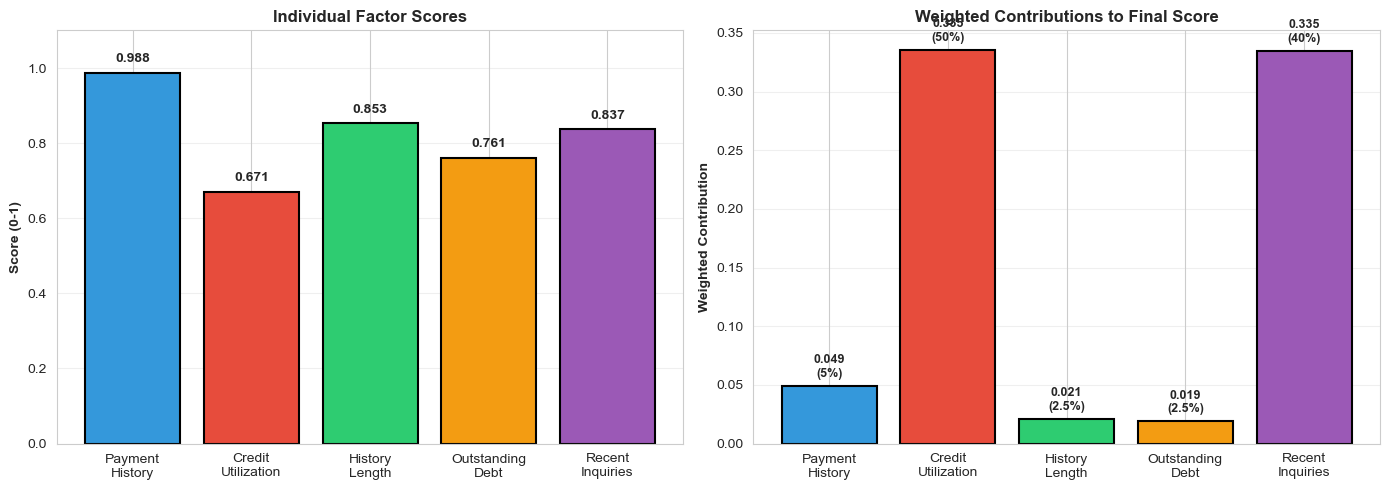


Total Weighted Sum: 0.7599
Final Score: 717 (Good)


In [12]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Factor scores
factors = ['Payment\nHistory', 'Credit\nUtilization', 'History\nLength', 'Outstanding\nDebt', 'Recent\nInquiries']
scores = [s_payment, s_utilization, s_history, s_debt, s_inquiries]
weights = [5, 50, 2.5, 2.5, 40]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
bars = ax1.bar(factors, scores, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Score (0-1)', fontweight='bold')
ax1.set_title('Individual Factor Scores', fontweight='bold', fontsize=12)
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Add score values on bars
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Weighted contributions
contributions = [w * s for w, s in zip([0.05, 0.50, 0.025, 0.025, 0.40], scores)]
bars2 = ax2.bar(factors, contributions, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Weighted Contribution', fontweight='bold')
ax2.set_title('Weighted Contributions to Final Score', fontweight='bold', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Add contribution values and weights
for bar, contrib, weight in zip(bars2, contributions, weights):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{contrib:.3f}\n({weight}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal Weighted Sum: {weighted_sum:.4f}")
print(f"Final Score: {final_score} ({tier})")

---

# Summary

This notebook demonstrated two independent credit assessment methods:

## Method 1: ML-Based Prediction
- **Input**: Customer financial data
- **Output**: Credit tier (Excellent/Good/Fair/Poor) + Credit limit
- **Approach**: Pre-trained XGBoost classifier
- **Credit Limit Formula**: $\text{Limit} = \text{Monthly Salary} \times 6 \times \text{Risk Factor}$

## Method 2: Statistical Scoring  
- **Input**: Customer financial data
- **Output**: Credit score (300-850)
- **Approach**: Weighted formula with 5 factors
- **Final Formula**: $\text{Score} = 300 + 550 \times \sum_{i=1}^{5} w_i \times s_i$

Both methods can be used independently or together for comprehensive credit assessment.

# Credit Scoring PoC - Business Demo

## Problem Statement
- Traditional credit assessment: **2-4 weeks**, manual review, expensive
- **Our solution:** Automated credit scoring in **seconds**
- **Impact:** Speed up decisions, reduce costs, better risk management

In [13]:
import sys
sys.path.insert(0, '/Users/surface/Documents/Oman/credit_score/backend')

import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Import our scoring functions
from simple_credit_score import (
    calculate_statistical_credit_score,
    get_user_data,
    score_user
)

# Set styling for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All dependencies loaded successfully!")

Note: MongoDB not available. Using JSON files for data.
✓ All dependencies loaded successfully!


## Sample Customer Data

Let's look at some real customers in our database:

In [14]:
# Load sample customers
data_file = Path('/Users/surface/Documents/Oman/credit_score/data/user_data.json')
with open(data_file, 'r') as f:
    all_users = json.load(f)

# Get unique customers
unique_customers = {}
for user in all_users:
    cid = user['Customer_ID']
    if cid not in unique_customers:
        unique_customers[cid] = user

# Sample 3 different customers
sample_ids = [3392, 8625, 38382]
sample_data = []

for user in all_users[:500]:  # Find our sample customers
    if user['Customer_ID'] in sample_ids and user['Customer_ID'] not in [s['Customer_ID'] for s in sample_data]:
        sample_data.append(user)

# Display sample customers
for customer in sample_data[:3]:
    print(f"\n{'='*60}")
    print(f"Customer: {customer['Name']} (ID: {customer['Customer_ID']})")
    print(f"{'='*60}")
    print(f"Occupation:        {customer['Occupation']}")
    print(f"Annual Income:     ${customer['Annual_Income']:,.0f}")
    print(f"Monthly Salary:    ${customer['Monthly_Inhand_Salary']:,.0f}")
    print(f"Credit Cards:      {customer['Num_Credit_Card']}")
    print(f"Bank Accounts:     {customer['Num_Bank_Accounts']}")
    print(f"Delayed Payments:  {customer['Num_of_Delayed_Payment']}")
    print(f"Outstanding Debt:  ${customer['Outstanding_Debt']:,.0f}")
    print(f"Credit Limit Change: {customer['Changed_Credit_Limit']}%")


Customer: Np (ID: 38382)
Occupation:        Lawyer
Annual Income:     $73,928
Monthly Salary:    $5,989
Credit Cards:      5
Bank Accounts:     4
Delayed Payments:  7
Outstanding Debt:  $548
Credit Limit Change: 10.14%

Customer: Aaron Maashoh (ID: 3392)
Occupation:        Scientist
Annual Income:     $19,114
Monthly Salary:    $1,825
Credit Cards:      4
Bank Accounts:     3
Delayed Payments:  6
Outstanding Debt:  $810
Credit Limit Change: 11.27%

Customer: Rick Rothackerj (ID: 8625)
Occupation:        Teacher
Annual Income:     $34,848
Monthly Salary:    $4,094
Credit Cards:      4
Bank Accounts:     2
Delayed Payments:  4
Outstanding Debt:  $605
Credit Limit Change: 5.42%


## Live Credit Score Demo

Now let's score these customers using our automated system:

In [15]:
# Score the sample customers
results = []

for customer in sample_data[:3]:
    cid = customer['Customer_ID']
    result = score_user(cid, use_ml=False)
    results.append(result)
    
    print(f"\n{'='*60}")
    print(f"CREDIT SCORE RESULT: {result['name']}")
    print(f"{'='*60}")
    
    stat = result['statistical_score']
    print(f"\n✓ SCORE: {stat['score']} ({stat['tier'].upper()})")
    print(f"\nRisk Level: ", end="")
    if stat['score'] >= 750:
        print("🟢 LOW RISK - Approve")
    elif stat['score'] >= 700:
        print("🟡 MEDIUM RISK - Approve with conditions")
    elif stat['score'] >= 650:
        print("🟠 MODERATE RISK - Review manually")
    else:
        print("🔴 HIGH RISK - Reject or request more info")
    
    print(f"\nScore Breakdown:")
    for factor, value in stat['breakdown'].items():
        bar = '█' * int(value * 20)
        print(f"  {factor:.<40} {bar} {value:.1%}")


CREDIT SCORE RESULT: Np

✓ SCORE: 723 (GOOD)

Risk Level: 🟡 MEDIUM RISK - Approve with conditions

Score Breakdown:
  payment_history......................... ███████████████████ 98.2%
  credit_utilization...................... █████████████ 68.4%
  credit_history_length................... ███████████████████ 95.5%
  outstanding_debt........................ ███████████████ 77.6%
  recent_inquiries........................ ████████████████ 83.7%

CREDIT SCORE RESULT: Aaron Maashoh

✓ SCORE: 704 (GOOD)

Risk Level: 🟡 MEDIUM RISK - Approve with conditions

Score Breakdown:
  payment_history......................... ███████████████████ 97.8%
  credit_utilization...................... ███████████████ 76.1%
  credit_history_length................... █████████████ 69.5%
  outstanding_debt........................ ██████████████ 70.3%
  recent_inquiries........................ █████████████ 67.9%

CREDIT SCORE RESULT: Rick Rothackerj

✓ SCORE: 717 (GOOD)

Risk Level: 🟡 MEDIUM RISK - Approve wit

## Visual Comparison

Compare scores across customers:

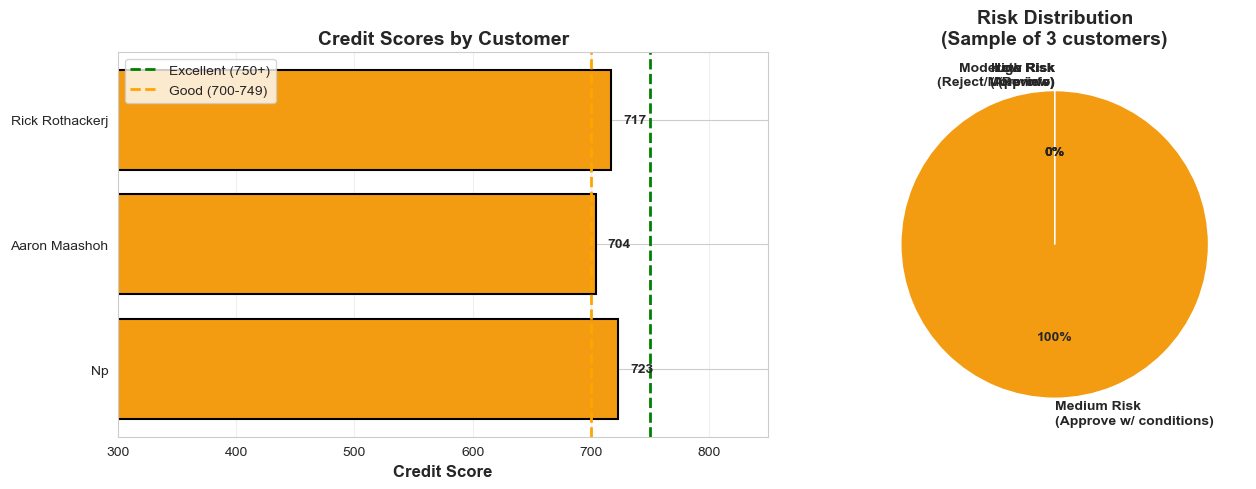


✓ Visualization complete!


In [16]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Credit Score Comparison
names = [r['name'] for r in results]
scores = [r['statistical_score']['score'] for r in results]
colors = ['#2ecc71' if s >= 750 else '#f39c12' if s >= 700 else '#e74c3c' for s in scores]

ax1 = axes[0]
bars = ax1.barh(names, scores, color=colors, edgecolor='black', linewidth=1.5)
ax1.axvline(x=750, color='green', linestyle='--', linewidth=2, label='Excellent (750+)')
ax1.axvline(x=700, color='orange', linestyle='--', linewidth=2, label='Good (700-749)')
ax1.set_xlabel('Credit Score', fontsize=12, fontweight='bold')
ax1.set_title('Credit Scores by Customer', fontsize=14, fontweight='bold')
ax1.set_xlim(300, 850)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add score labels on bars
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax1.text(score + 10, i, f'{score}', va='center', fontweight='bold')

# Plot 2: Risk Distribution
risk_categories = []
risk_counts = [0, 0, 0, 0]

for r in results:
    score = r['statistical_score']['score']
    if score >= 750:
        risk_counts[0] += 1
    elif score >= 700:
        risk_counts[1] += 1
    elif score >= 650:
        risk_counts[2] += 1
    else:
        risk_counts[3] += 1

ax2 = axes[1]
risk_labels = ['Low Risk\n(Approve)', 'Medium Risk\n(Approve w/ conditions)', 'Moderate Risk\n(Review)', 'High Risk\n(Reject/More info)']
risk_colors = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
ax2.pie(risk_counts, labels=risk_labels, colors=risk_colors, autopct='%1.0f%%',
        startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('Risk Distribution\n(Sample of 3 customers)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

## Scoring Factors Explained

Our credit score is based on 5 key factors:

In [17]:
# Show factor importance
factors = {
    'Credit Utilization': {'weight': 50, 'meaning': 'How much of available credit is used (lower is better)'},
    'Recent Inquiries': {'weight': 40, 'meaning': 'How many recent credit inquiries (fewer is better)'},
    'Payment History': {'weight': 5, 'meaning': 'On-time payment ratio (higher is better)'},
    'Credit History Length': {'weight': 2.5, 'meaning': 'How long credit account is open (longer is better)'},
    'Outstanding Debt': {'weight': 2.5, 'meaning': 'Total outstanding debt (lower is better)'}
}

print("\nFACTOR IMPORTANCE:")
print("="*80)

import math
for factor, info in factors.items():
    weight = info['weight']
    meaning = info['meaning']
    # Show at least one block for small weights and cap to 10 blocks
    bar_len = min(10, max(1, int(math.ceil(weight / 5))))
    bar = '█' * bar_len
    print(f"\n{factor}")
    print(f"  Weight: {weight}% {bar}")
    print(f"  Meaning: {meaning}")

print("\n" + "="*80)
print(f"\nScore Range: 300 - 850 (standard credit score range)")
print(f"  🟢 750+     = Excellent (Low Risk)")
print(f"  🟡 700-749  = Good (Medium Risk)")
print(f"  🟠 650-699  = Fair (Moderate Risk)")
print(f"  🔴 Below 650 = Poor (High Risk)")


FACTOR IMPORTANCE:

Credit Utilization
  Weight: 50% ██████████
  Meaning: How much of available credit is used (lower is better)

Recent Inquiries
  Weight: 40% ████████
  Meaning: How many recent credit inquiries (fewer is better)

Payment History
  Weight: 5% █
  Meaning: On-time payment ratio (higher is better)

Credit History Length
  Weight: 2.5% █
  Meaning: How long credit account is open (longer is better)

Outstanding Debt
  Weight: 2.5% █
  Meaning: Total outstanding debt (lower is better)


Score Range: 300 - 850 (standard credit score range)
  🟢 750+     = Excellent (Low Risk)
  🟡 700-749  = Good (Medium Risk)
  🟠 650-699  = Fair (Moderate Risk)
  🔴 Below 650 = Poor (High Risk)


## Key Metrics & Insights

Let's analyze the overall data:

In [18]:
# Calculate statistics from all users
all_scores = []
all_incomes = []
all_debts = []

for user in all_users[:5000]:  # Sample of 5000 users
    score, tier, breakdown = calculate_statistical_credit_score(user)
    all_scores.append(score)
    all_incomes.append(user.get('Annual_Income', 0))
    all_debts.append(user.get('Outstanding_Debt', 0))

print("\n" + "="*60)
print("DATABASE STATISTICS (Sample of 5,000 customers)")
print("="*60)

print(f"\nCREDIT SCORES:")
print(f"  Average Score:     {np.mean(all_scores):.0f}")
print(f"  Median Score:      {np.median(all_scores):.0f}")
print(f"  Min Score:         {np.min(all_scores):.0f}")
print(f"  Max Score:         {np.max(all_scores):.0f}")

low_risk = sum(1 for s in all_scores if s >= 750) / len(all_scores) * 100
medium_risk = sum(1 for s in all_scores if 700 <= s < 750) / len(all_scores) * 100
high_risk = sum(1 for s in all_scores if s < 700) / len(all_scores) * 100

print(f"\nRISK DISTRIBUTION:")
print(f"  🟢 Low Risk (750+):      {low_risk:.1f}%")
print(f"  🟡 Medium Risk (700-749): {medium_risk:.1f}%")
print(f"  🔴 High Risk (<700):     {high_risk:.1f}%")

print(f"\nFINANCIAL METRICS:")
print(f"  Average Annual Income:   ${np.mean(all_incomes):,.0f}")
print(f"  Average Outstanding Debt: ${np.mean(all_debts):,.0f}")
print(f"  Debt-to-Income Ratio:    {(np.mean(all_debts) / np.mean(all_incomes) * 100):.1f}%")

print("\n" + "="*60)


DATABASE STATISTICS (Sample of 5,000 customers)

CREDIT SCORES:
  Average Score:     611
  Median Score:      614
  Min Score:         300
  Max Score:         767

RISK DISTRIBUTION:
  🟢 Low Risk (750+):      1.1%
  🟡 Medium Risk (700-749): 18.5%
  🔴 High Risk (<700):     80.4%

FINANCIAL METRICS:
  Average Annual Income:   $50,831
  Average Outstanding Debt: $1,420
  Debt-to-Income Ratio:    2.8%



## Business Impact & ROI

**Current State (Manual Process):**
- Time per application: 2-4 weeks
- Cost per application: $50-100
- Manual errors: 5-10%

**With Automated Scoring:**
- Time per application: **< 1 second**
- Cost per application: **< $0.01**
- Manual errors: **Near 0%** (algorithm is consistent)

**For 1,000 applications per month:**
- Time saved: 666-1,333 staff-hours
- Cost savings: $50,000-100,000
- Error reduction: 50-100 fewer mistakes

## Next Steps

1. **Integration**: Connect to your banking system for real-time scoring
2. **Customization**: Adjust weights based on your business rules
3. **ML Enhancement**: Add advanced models for even better predictions
4. **Scalability**: Deploy as API for all channels (web, mobile, branch)
5. **Monitoring**: Track model performance over time

---

**Ready to transform your credit assessment process?**